# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

Matplotlib is building the font cache; this may take a moment.


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.head()


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [6]:
train_df.shape

(750000, 18)

In [7]:
#  =================Checking missing values for both the datasets========================
missing_train = train_df.isnull().mean() * 100
missing_test = test_df.isnull().mean() * 100
print(f"\nMissing Values in Training Dataset : {missing_train}")
print(f"\nMissing Values in Testing Dataset : {missing_test}")


Missing Values in Training Dataset : id           0.0
age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
y            0.0
dtype: float64

Missing Values in Testing Dataset : id           0.0
age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
dtype: float64


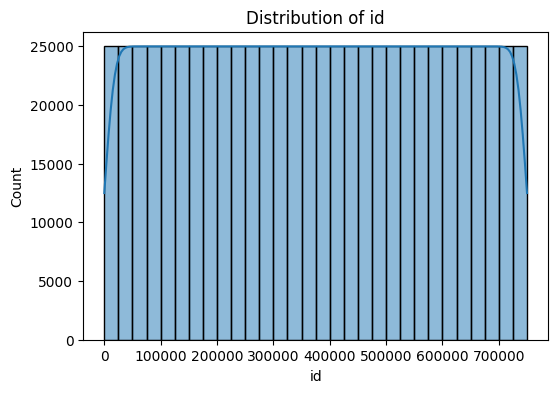

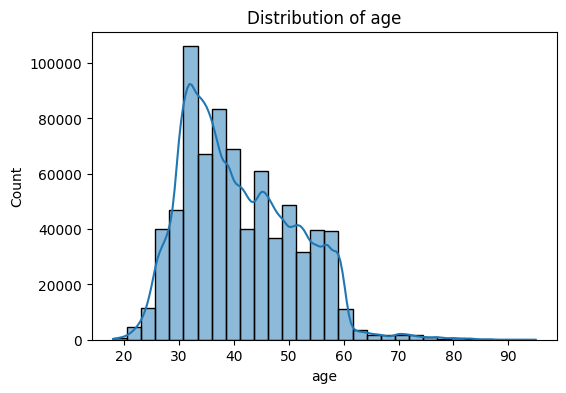

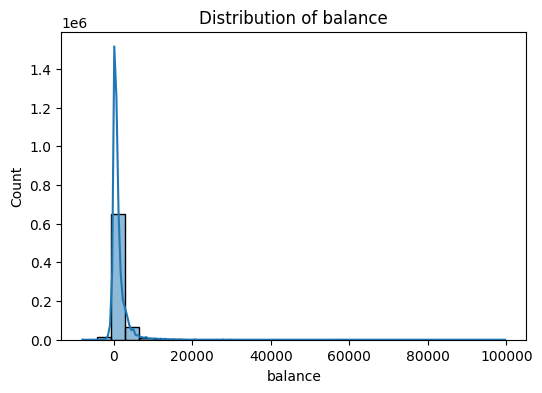

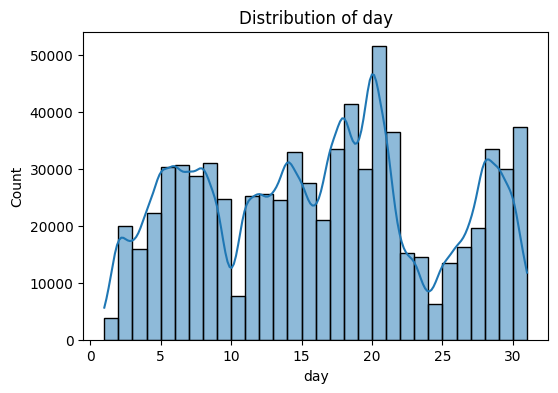

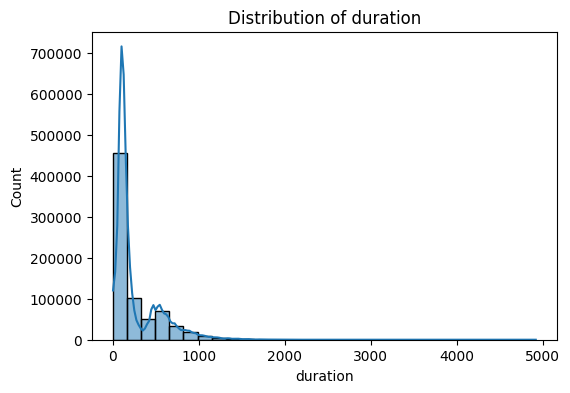

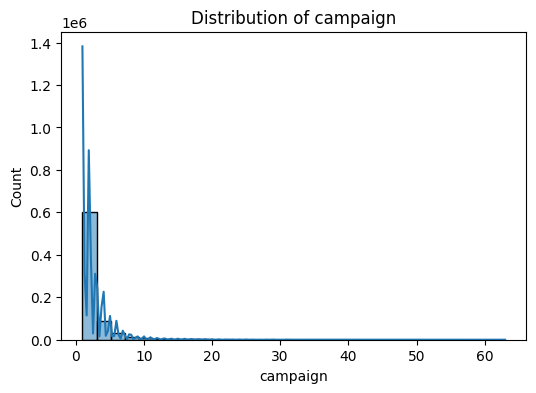

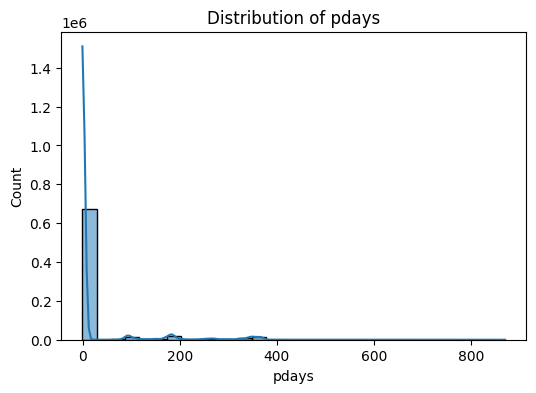

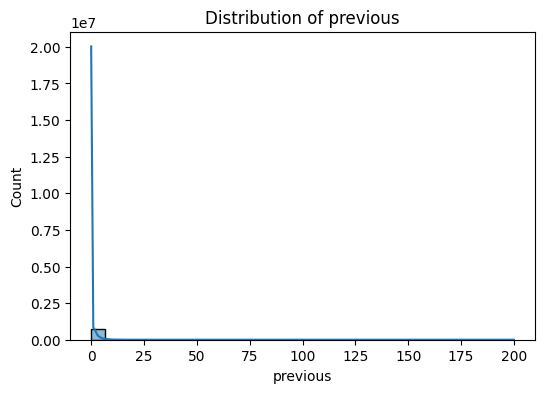

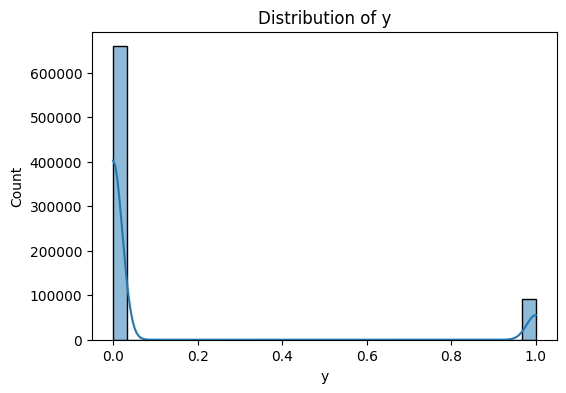

In [8]:
#================= Plot Distributions of Numerical Columns of Training Dataset =======================
num_cols_train = train_df.select_dtypes(include=['int64','float64']).columns

for col in num_cols_train:
    col_data = train_df[col].replace([np.inf, -np.inf], np.nan).dropna()

    plt.figure(figsize=(6,4))
    sns.histplot(col_data, kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


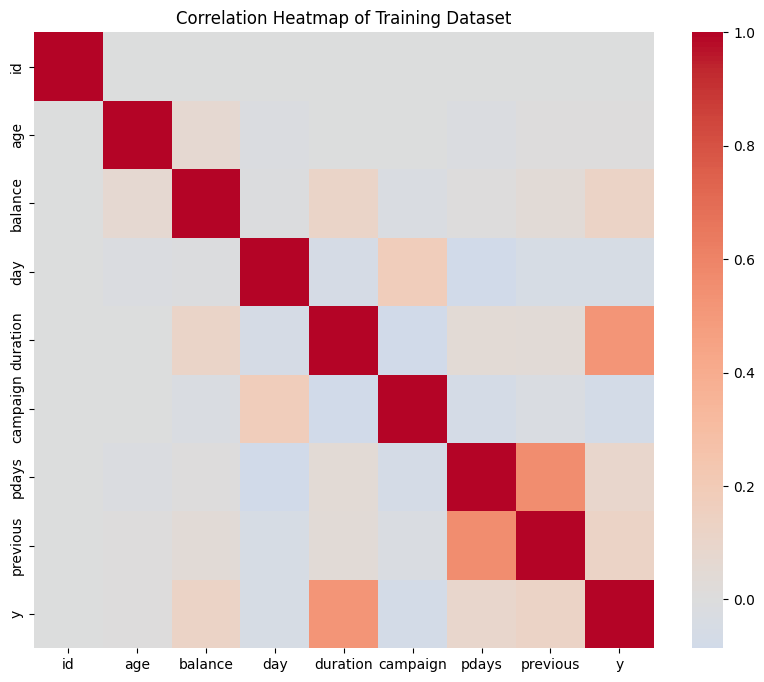

In [9]:
#================= Correaltions of Numerical Columns of Training & Testing Datasets=======================

plt.figure(figsize=(10,8))
corr_train = train_df[num_cols_train].corr()
sns.heatmap(corr_train, annot=False,cmap="coolwarm",center=0)
plt.title("Correlation Heatmap of Training Dataset")
plt.show()

In [10]:
#================Show top categories and counts for categorical features==================
cat_cols_train = train_df.select_dtypes(include=['object']).columns
for cols in cat_cols_train:
    print(f"\n{cols} - unique: {train_df[cols].nunique()}")
    print(train_df[cols].value_counts().head(10))


job - unique: 12
job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
Name: count, dtype: int64

marital - unique: 3
marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64

education - unique: 4
education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64

default - unique: 2
default
no     737151
yes     12849
Name: count, dtype: int64

housing - unique: 2
housing
yes    411288
no     338712
Name: count, dtype: int64

loan - unique: 2
loan
no     645023
yes    104977
Name: count, dtype: int64

contact - unique: 3
contact
cellular     486655
unknown      231627
telephone     31718
Name: count, dtype: int64

month - unique: 12
month
may    228411
aug    128859
jul    110647
jun     93670
nov     66062
apr    

In [11]:
#preprocess
X_train = train_df.drop(["y"], axis = 1)
y_train = train_df["y"]
X_test = test_df

In [12]:
cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(include=['int64','float64']).columns

In [13]:
X_train_encoded = pd.get_dummies(X_train[cat_cols])
X_test_encoded = pd.get_dummies(X_test[cat_cols])

In [14]:
X_train_encoded, X_test_encoded = X_train_encoded.align(
        X_test_encoded, join="left", axis=1, fill_value=0)

In [15]:
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[num_cols])
X_test_num_scaled = scaler.fit_transform(X_test[num_cols])

# Convert scaled arrays back to DataFrame with column names
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=num_cols, index=X_train.index)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=num_cols, index=X_test.index)


In [16]:
X_train_final = pd.concat([X_train_num_scaled, X_train_encoded], axis=1)
X_test_final = pd.concat([X_test_num_scaled, X_test_encoded], axis=1)

In [18]:
model = XGBClassifier(
            n_estimators=500, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8, eval_metric="auc",
            random_state=42, use_label_encoder=False, n_jobs=-1
        )
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scores = cross_val_score(model, X_train_final, y_train, cv=skf, scoring="roc_auc", n_jobs=-1)
print(f"Cross-validation scores: {scores}")
print(f"Mean CV score: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation scores: [0.96711194 0.9658782  0.96599983 0.96696965 0.96628906]
Mean CV score: 0.9664 ± 0.0005


In [21]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    # Define hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0)
    }

    # Define model
    model = XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric="auc",
        **params
    )

    # Cross-validation AUC
    scores = cross_val_score(
        model,
        X_train_final,   # ✅ full training data
        y_train,
        cv=cv,
        scoring="roc_auc"
    )

    return scores.mean()


# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best parameters:", study.best_params)
print("Best CV AUC:", study.best_value)


[I 2025-08-29 12:08:10,842] A new study created in memory with name: no-name-80023c74-0a83-44cd-8246-1090e56ed326
[I 2025-08-29 12:10:24,052] Trial 0 finished with value: 0.9670274551835846 and parameters: {'n_estimators': 308, 'learning_rate': 0.03729180960098588, 'max_depth': 12, 'subsample': 0.7317632491677026, 'colsample_bytree': 0.9149406913792991, 'gamma': 1.0133546693060536, 'min_child_weight': 2, 'scale_pos_weight': 2.346363864257794}. Best is trial 0 with value: 0.9670274551835846.
[I 2025-08-29 12:14:25,182] Trial 1 finished with value: 0.9636897998351858 and parameters: {'n_estimators': 992, 'learning_rate': 0.23226394652359997, 'max_depth': 7, 'subsample': 0.6193016669611877, 'colsample_bytree': 0.6097293430919654, 'gamma': 0.23153408085873017, 'min_child_weight': 4, 'scale_pos_weight': 2.6954731266923524}. Best is trial 0 with value: 0.9670274551835846.
[I 2025-08-29 12:17:27,962] Trial 2 finished with value: 0.9659685638494281 and parameters: {'n_estimators': 502, 'learni

Best parameters: {'n_estimators': 742, 'learning_rate': 0.06490823317867837, 'max_depth': 10, 'subsample': 0.8278170141102676, 'colsample_bytree': 0.7554538575799636, 'gamma': 3.4841160765155763, 'min_child_weight': 10, 'scale_pos_weight': 5.529166887401541}
Best CV AUC: 0.9675506936240297


In [22]:
best_params = study.best_params
final_model = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric="auc",
    **best_params
)

final_model.fit(X_train_final, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7554538575799636
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [23]:
y_test_pred = final_model.predict_proba(X_test_final)[:, 1]

In [24]:
submission = pd.DataFrame({
    "id": test_df["id"],       
    "y": y_test_pred
})

submission.to_csv("submission.csv", index=False)